This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray CfRadial2 backend

In this example, we read CfRadial2 data files using the xarray `cfradial2` backend.

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Load CfRadial1 Volume Data

In [2]:
fpath = 'netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR_cfradial2.nc'
f = wrl.util.get_wradlib_data_file(fpath)
vol = wrl.io.open_cfradial2_dataset(f)

### Inspect RadarVolume

In [3]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 9)
Elevation(s): (0.5, 1.1, 1.8, 2.6, 3.6, 4.7, 6.5, 9.1, 12.8)

### Inspect root group

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [4]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Coordinates:
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 120.4
    altitude             float64 45.0
    time                 datetime64[ns] 2008-06-04T00:15:03
    latitude             float64 22.53
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2008-06-04T00:15:03Z'
    time_coverage_end    <U20 '2008-06-04T00:22:16Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_7' 'sweep_8'
    sweep_fixed_angle    (sweep) float64 0.5 1.1 1.8 2.6 3.6 4.7 6.5 9.1 12.8
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.5

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [5]:
display(vol[0])

<xarray.Dataset>
Dimensions:             (azimuth: 480, range: 996)
Coordinates:
    sweep_mode          <U20 ...
    rtime               (azimuth) datetime64[ns] 2008-06-04T00:15:34 ... 2008...
  * range               (range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
  * azimuth             (azimuth) float32 0.0 0.75 1.5 ... 357.8 358.5 359.2
    elevation           (azimuth) float32 ...
    longitude           float64 ...
    latitude            float64 ...
    altitude            float64 ...
    time                datetime64[ns] 2008-06-04T00:15:03
Data variables: (12/16)
    sweep_number        int32 ...
    polarization_mode   |S32 ...
    prt_mode            |S32 ...
    follow_mode         |S32 ...
    fixed_angle         float32 ...
    target_scan_rate    float32 ...
    ...                  ...
    antenna_transition  (azimuth) int8 ...
    n_samples           (azimuth) int32 ...
    r_calib_index       (azimuth) int8 ...
    scan_rate           (azimuth) float32 ...
    DBZ                 (azimuth, range) float32 ...
    VR                  (azimuth, range) float32 ...
Attributes:
    fixed_angle:  0.5

### Goereferencing

In [6]:
swp = vol[0].copy().pipe(wrl.georef.georeference_dataset)

### Plotting

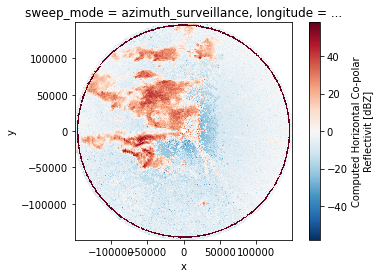

In [7]:
swp.DBZ.plot.pcolormesh(x='x', y='y')
pl.gca().set_aspect('equal')

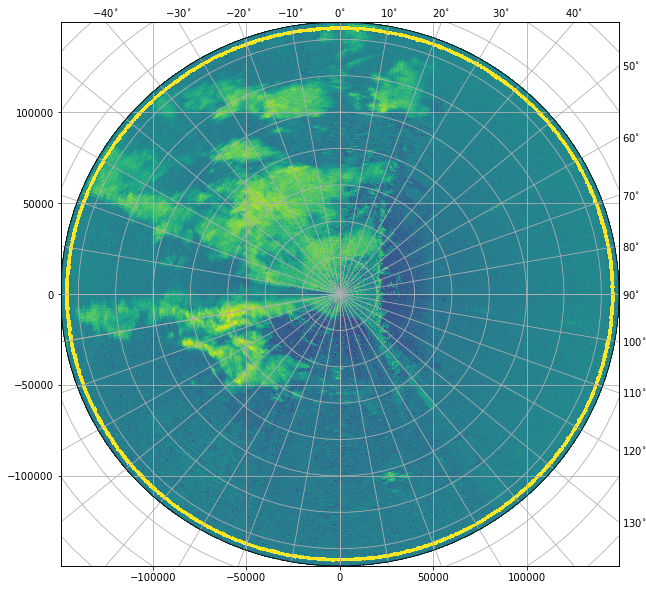

In [8]:
fig = pl.figure(figsize=(10,10))
swp.DBZ.wradlib.plot_ppi(proj='cg', fig=fig)

In [9]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7f8095dfdb30> >


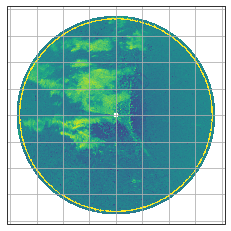

In [10]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                      central_longitude=swp.longitude.values)
pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

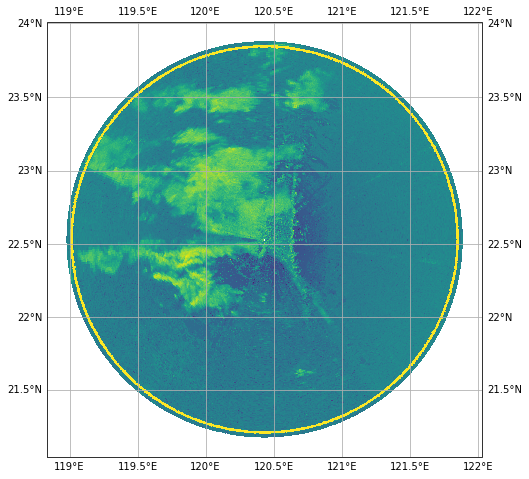

In [11]:
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

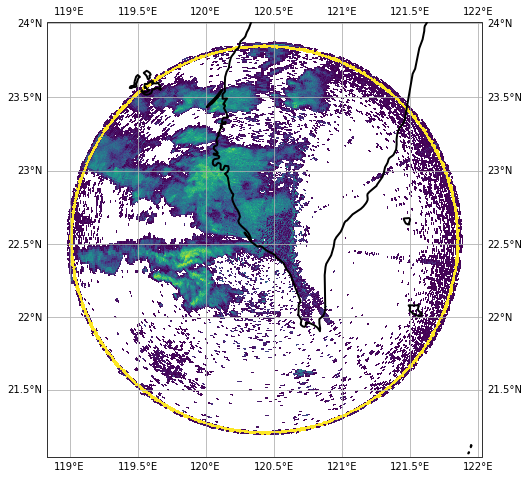

In [12]:
import cartopy.feature as cfeature
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='physical',
                                           name='coastline',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=2, zorder=4)

map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)

DBZ = swp.DBZ
pm = DBZ.where(DBZ > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

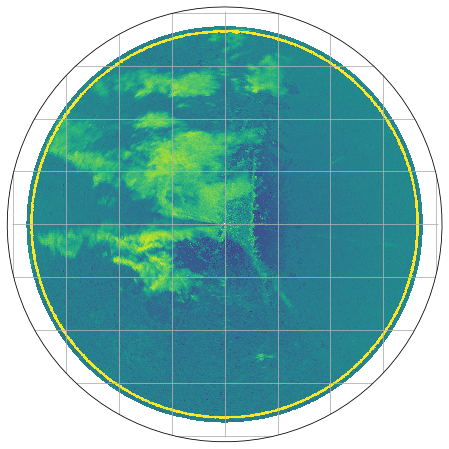

In [13]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                                     central_longitude=swp.longitude.values,
                                    )
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = swp.DBZ.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

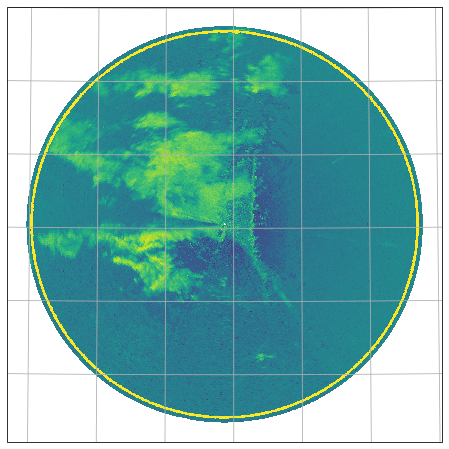

In [14]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=swp.latitude.values, 
                               central_longitude=swp.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZ.wradlib.plot_ppi(ax=ax)
ax.gridlines()

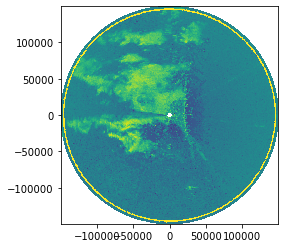

In [15]:
swp.DBZ.wradlib.plot_ppi()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray has dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial standard.

In [16]:
display(swp.DBZ)

<xarray.DataArray 'DBZ' (azimuth: 480, range: 996)>
array([[ 20.699957,  39.96934 ,  29.650644, ...,  -2.799595,  -3.549335,
         -1.650112],
       [ 13.829709,  35.710747,   8.869345, ..., -18.780428,  -3.080303,
         -4.519378],
       [ -9.129745,  14.810412,   4.539685, ...,   0.179822,  -0.550375,
         -3.519132],
       ...,
       [  5.889927,  26.049406,  32.379555, ...,  -2.550866,  -1.060269,
         -1.900617],
       [  0.959765,  23.579884,   9.29929 , ...,  -8.680257,  -5.039932,
         -2.410512],
       [ 20.079912,  39.15031 ,  13.190121, ...,  -4.91912 ,  -3.160252,
         -1.319658]], dtype=float32)
Coordinates: (12/15)
    sweep_mode  <U20 'azimuth_surveillance'
    rtime       (azimuth) datetime64[ns] 2008-06-04T00:15:34 ... 2008-06-04T0...
  * range       (range) float32 150.0 300.0 450.0 ... 1.492e+05 1.494e+05
  * azimuth     (azimuth) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
    elevation   (azimuth) float32 0.5164 0.5219 0.5164 ... 0.5219 0.5219 0.5219
    longitude   float64 120.4
    ...          ...
    x           (azimuth, range) float32 -6.556e-06 -1.311e-05 ... -1.955e+03
    y           (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.493e+05
    z           (azimuth, range) float32 46.0 47.0 48.0 ... 2.714e+03 2.718e+03
    gr          (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
    rays        (azimuth, range) float32 0.0 0.0 0.0 0.0 ... 359.2 359.2 359.2
    bins        (azimuth, range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
Attributes:
    long_name:             Computed Horizontal Co-polar Reflectivit
    standard_name:         equivalent_reflectivity_factor
    units:                 dBZ
    threshold_field_name:  
    threshold_value:       -9999.0
    sampling_ratio:        1.0
    grid_mapping:          grid_mapping

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

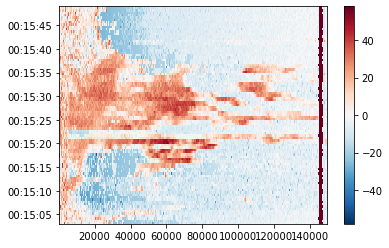

In [17]:
swp.DBZ.sortby('rtime').plot(x="range", y="rtime", add_labels=False)

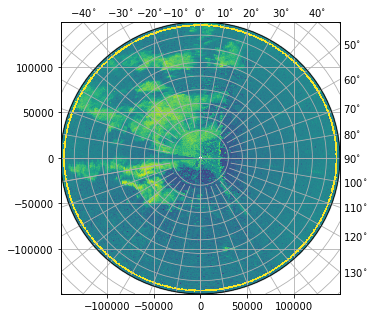

In [18]:
fig = pl.figure(figsize=(5,5))
pm = swp.DBZ.wradlib.plot_ppi(proj={'latmin': 33e3}, fig=fig)

### Mask some values

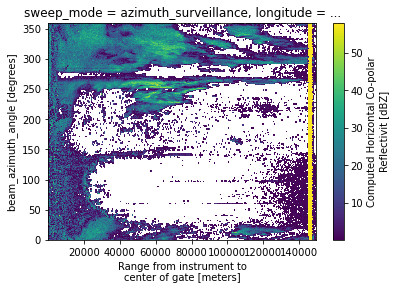

In [19]:
swp['DBZ'] = swp['DBZ'].where(swp['DBZ'] >= 0)
swp['DBZ'].plot()

### Export to ODIM and CfRadial2

In [20]:
vol.to_odim('cfradial2_as_odim.h5')
vol.to_cfradial2('cfradial2_as_cfradial2.nc')

### Import again

In [21]:
vola = wrl.io.open_odim_dataset('cfradial2_as_odim.h5')

In [22]:
volb = wrl.io.open_cfradial2_dataset('cfradial2_as_cfradial2.nc')

### Check equality

Some variables need to be dropped, since they are not exported to the other standards or differ slightly (eg. re-indexed ray times).

In [23]:
drop = set(vol[0]) ^ set(vola[0]) | set({"elevation", "rtime"})
xr.testing.assert_allclose(vol.root, vola.root)
xr.testing.assert_allclose(vol[0].drop_vars(drop), vola[0].drop_vars(drop, errors="ignore"))
xr.testing.assert_allclose(vol.root, volb.root)
xr.testing.assert_equal(vol[0], volb[0])
xr.testing.assert_allclose(vola.root, volb.root)
xr.testing.assert_allclose(vola[0].drop_vars(drop, errors="ignore"), volb[0].drop_vars(drop, errors="ignore"))

## More CfRadial2 loading mechanisms

### Use `xr.open_dataset` to retrieve explicit group


In [24]:
swp = xr.open_dataset(f, engine="cfradial2", group="sweep_8")
display(swp)

<xarray.Dataset>
Dimensions:             (azimuth: 480, range: 996)
Coordinates:
    sweep_mode          <U20 ...
    rtime               (azimuth) datetime64[ns] ...
  * range               (range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
  * azimuth             (azimuth) float32 0.0 0.75 1.5 ... 357.8 358.5 359.2
    elevation           (azimuth) float32 ...
    longitude           float64 ...
    latitude            float64 ...
    altitude            float64 ...
    time                datetime64[ns] ...
Data variables: (12/16)
    sweep_number        int32 ...
    polarization_mode   |S32 ...
    prt_mode            |S32 ...
    follow_mode         |S32 ...
    fixed_angle         float32 ...
    target_scan_rate    float32 ...
    ...                  ...
    antenna_transition  (azimuth) int8 ...
    n_samples           (azimuth) int32 ...
    r_calib_index       (azimuth) int8 ...
    scan_rate           (azimuth) float32 ...
    DBZ                 (azimuth, range) float32 ...
    VR                  (azimuth, range) float32 ...
Attributes:
    fixed_angle:  12.8